# Pruebas de la libreria [skfuzzy](https://pythonhosted.org/scikit-fuzzy/) de SciKit

Para instalar la libreria ejectar en una terminal:

    pip install -U scikit-fuzzy

Ejemplo basado en el [ejemplo oficial](https://github.com/scikit-fuzzy/scikit-fuzzy/blob/master/docs/examples/plot_control_system_advanced.py) de Skfuzzy

In [1]:
import numpy as np
import skfuzzy.control as fzctrl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

En primer lugar voy a diseñar un sistema de control difuso para la plataforma utilizando como entrada unicamente el error a la posicion deseada y como salida la inclinacion.\
Ademas el controlador se va a diseñar en 1 dimension, de forma tal que podamos combinar controladores de forma experimental en cada eje.

In [2]:
#Constantes
ANCHO_PLATAFORMA = 0.3#m
ANGULO_MAXIMO = 20#º

In [3]:
#Creo las variables difusas. 1 entrada, 1 salida

#Entrada
error = fzctrl.Antecedent(np.linspace(0, ANCHO_PLATAFORMA, 5), 'error')

#Salida
angulo = fzctrl.Consequent(np.linspace(-ANGULO_MAXIMO, ANGULO_MAXIMO, 5), 'angulo')

#Creo las funciones de membresia ("categoria" de cada variable)
#Por simplicidad las genero de forma automatica pero se puede jugar con la forma y ancho de banda de cada categoria.
nombres = ['ng', 'np', 'ce', 'pp', 'pg'] #Negativo grande, negativo pequeño, cero, positivo pequeño y positivo grande.
error.automf(names=nombres)
angulo.automf(names=nombres)

Grafico los sets

/home/ordonez/.local/lib/python3.8/site-packages/skfuzzy/control/fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


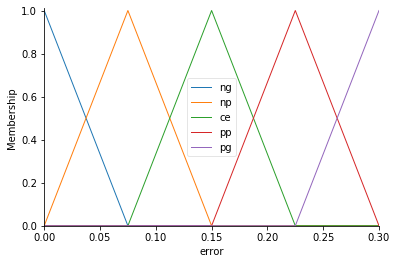

In [4]:
error.view()

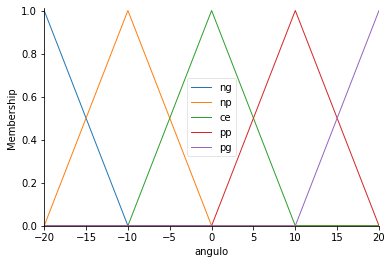

In [5]:
angulo.view()

## Defino las reglas

In [6]:
#Si el error es negativo grande entonces el angulo es positivo grande
regla0 = fzctrl.Rule(antecedent=error['ng'], consequent=angulo['pg'], label='Regla pg')
#Si el error es negativo pequeño entonces el angulo es positivo pequeño
regla1 = fzctrl.Rule(antecedent=error['np'], consequent=angulo['pp'], label='Regla pp')
#Si el error es cero entonces el angulo es cero
regla2 = fzctrl.Rule(antecedent=error['ce'], consequent=angulo['ce'], label='Regla ce')
#Si el error es positivo pequeño entonces el angulo es negativo pequeño
regla3 = fzctrl.Rule(antecedent=error['pp'], consequent=angulo['np'], label='Regla np')
#Si el error es positivo grande entonces el angulo es negativo grande
regla4 = fzctrl.Rule(antecedent=error['pg'], consequent=angulo['ng'], label='Regla ng')


## Simulamos el sistema y visualizamos la curva de control

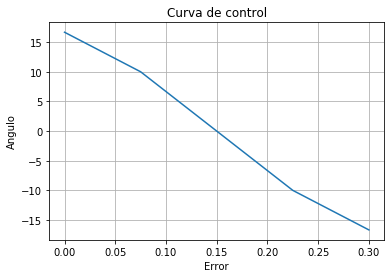

In [7]:
sistema = fzctrl.ControlSystem([regla0, regla1, regla2, regla3, regla4])

simulacion = fzctrl.ControlSystemSimulation(sistema)

curva = np.zeros(len(error.universe))
for i, entrada in enumerate(error.universe):
    simulacion.input['error'] = entrada
    simulacion.compute()
    curva[i] = simulacion.output['angulo']

plt.plot(error.universe, curva)
plt.xlabel('Error')
plt.ylabel('Angulo')
plt.title('Curva de control')
plt.grid(True)

In [8]:
#Elimino todas las variables por las dudas
#%reset -f

## Para la segunda prueba voy a probar usar como entrada tambien la velocidad

In [9]:
VELOCIDAD_MAXIMA = 0.3#m/s

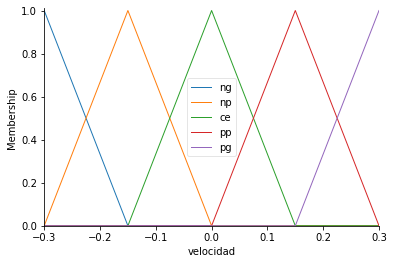

In [10]:
#Entrada 2
velocidad = fzctrl.Antecedent(np.linspace(-VELOCIDAD_MAXIMA, VELOCIDAD_MAXIMA, 5), 'velocidad')
velocidad.automf(names=nombres)
velocidad.view()

## Defino las reglas

In [11]:
regla0 = fzctrl.Rule(antecedent=((error['ng'] & velocidad['pg']) | 
                                 (error['ng'] & velocidad['pp']) | 
                                 (error['np'] & velocidad['pg'])),
                                 consequent=angulo['pg'], label='Regla pg')


regla1 = fzctrl.Rule(antecedent=((error['ng'] & velocidad['ce']) | 
                                 (error['ng'] & velocidad['np']) | 
                                 (error['np'] & velocidad['pp']) | 
                                 (error['np'] & velocidad['ce']) | 
                                 (error['ce'] & velocidad['pp']) | 
                                 (error['ce'] & velocidad['pg']) | 
                                 (error['pp'] & velocidad['pg'])),
                                 consequent=angulo['pp'], label='Regla pp')


regla2 = fzctrl.Rule(antecedent=((error['ng'] & velocidad['ng']) | 
                                 (error['np'] & velocidad['np']) | 
                                 (error['ce'] & velocidad['ce']) | 
                                 (error['pp'] & velocidad['pp']) | 
                                 (error['pg'] & velocidad['pg']) | 
                                 (error['pp'] & velocidad['pg'])),
                                 consequent=angulo['ce'], label='Regla ce')


regla3 = fzctrl.Rule(antecedent=((error['pg'] & velocidad['ce']) | 
                                 (error['pg'] & velocidad['pp']) | 
                                 (error['pp'] & velocidad['np']) | 
                                 (error['pp'] & velocidad['ce']) | 
                                 (error['ce'] & velocidad['np']) | 
                                 (error['ce'] & velocidad['ng']) | 
                                 (error['np'] & velocidad['ng'])),
                                 consequent=angulo['np'], label='Regla np')


regla4 = fzctrl.Rule(antecedent=((error['pg'] & velocidad['ng']) | 
                                 (error['pg'] & velocidad['np']) | 
                                 (error['pp'] & velocidad['ng'])),
                                 consequent=angulo['ng'], label='Regla ng')



## Simulamos el sistema y visualizamos la superficie de control

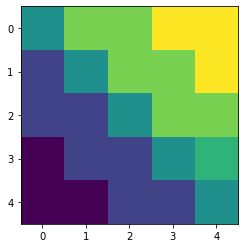

In [12]:
sistema = fzctrl.ControlSystem([regla0, regla1, regla2, regla3, regla4])

simulacion = fzctrl.ControlSystemSimulation(sistema)

superficie = np.zeros((len(error.universe), len(velocidad.universe)))
for i, err in enumerate(error.universe):
    for j, vel in enumerate(velocidad.universe):
        simulacion.input['error'] = err
        simulacion.input['velocidad'] = vel
        simulacion.compute()
        superficie[i,j] = simulacion.output['angulo']

plt.imshow(superficie)

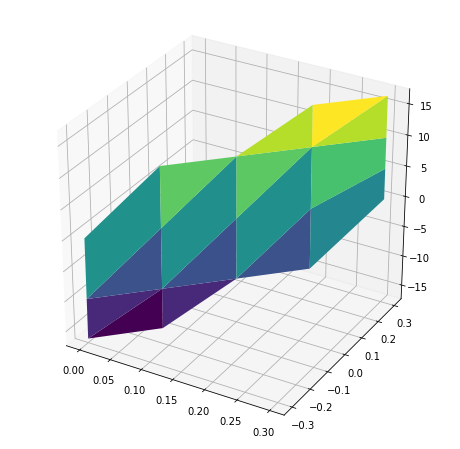

In [13]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(error.universe, velocidad.universe, superficie, cmap='viridis')

In [14]:
%timeit simulacion.compute()

32.5 µs ± 633 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
